<a href="https://colab.research.google.com/github/pqhunter15/LendingClubModeling/blob/main/lending_club_pqh_process_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# conda create -n lending_club pyod scikit-learn pandas pyarrow scipy matplotlib numpy seaborn shap xgboost ipykernel

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Ensure full column display in Jupyter
pd.set_option("display.width", 300)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option("display.max_colwidth", 50)   # prevent wrapping, truncate >50 chars

# Loading Data

In [ ]:

# GitHub raw file URL
sample_url = "https://github.com/rfox12-edu/p2p-lending/raw/refs/heads/main/sample.parquet?download="
full_url = "https://github.com/rfox12-edu/p2p-lending/raw/refs/heads/main/accepted_2007_to_2018Q3.parquet?download="

# Read the Parquet file into a DataFrame
df = pd.read_parquet(sample_url, engine="pyarrow")

# Preview the first few rows
print(df.head())
print("Rows and columns: ", df.shape)


          id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  installment grade sub_grade                emp_title emp_length home_ownership  annual_inc verification_status   issue_d  loan_status pymnt_plan                                                url  desc  \
0  107843697        NaN     5000.0       5000.0           5000.0   36 months      8.24       157.24     B        B1  Field Services Instaler  10+ years       MORTGAGE     54000.0     Source Verified  May-2017   Fully Paid          n  https://lendingclub.com/browse/loanDetail.acti...  None   
1   55289858        NaN     9975.0       9975.0           9975.0   36 months     20.99       375.76     E        E5      Corrections Officer  10+ years           RENT     65878.0            Verified  Jul-2015   Fully Paid          n  https://lendingclub.com/browse/loanDetail.acti...  None   
2  121265952        NaN    28050.0      28050.0          28050.0   60 months     11.99       623.82     B        B5  staf

# Inspect / Remove Data

## Remove ID Data

In [ ]:
print("Rows and columns: ", df.shape)
drop_columns = [
    # Empty / Metadata
    "id", "member_id", "url",
]
df.drop(columns=drop_columns, inplace=True)
print("Rows and columns: ", df.shape)

Rows and columns:  (20000, 151)
Rows and columns:  (20000, 148)


## Remove Joint Application Data   

In [ ]:
# Analyze the distribution of application types (Joint vs Individual) and their corresponding loan statuses
pd.crosstab(df['application_type'], df['loan_status'])

loan_status,Charged Off,Current,Does not meet the credit policy. Status:Charged Off,Does not meet the credit policy. Status:Fully Paid,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days)
application_type,,,,,,,,
Individual,2335,6937,7,19,9332,108,47,189
Joint App,55,774,0,0,159,9,4,25


In [ ]:
print("Rows and columns: ", df.shape)
df.drop(df[df["application_type"] == "Joint App"].index, inplace=True)
drop_columns = [
    # Joint applications
    "application_type", "annual_inc_joint", "dti_joint", "verification_status_joint", "revol_bal_joint",
    "sec_app_fico_range_low", "sec_app_fico_range_high", "sec_app_earliest_cr_line", "sec_app_inq_last_6mths",
    "sec_app_mort_acc", "sec_app_open_acc", "sec_app_revol_util", "sec_app_open_act_il",
    "sec_app_num_rev_accts", "sec_app_chargeoff_within_12_mths", "sec_app_collections_12_mths_ex_med", "sec_app_mths_since_last_major_derog"
]
df.drop(columns=drop_columns, inplace=True)
print("Rows and columns: ", df.shape)

Rows and columns:  (20000, 148)
Rows and columns:  (18974, 131)


## Remove Hardship & Settlement Data

In [ ]:
print("Rows and columns: ", df.shape)
drop_columns = [
    # Hardship & Settlement
    "hardship_flag", "hardship_type", "hardship_reason", "hardship_status",
    "deferral_term", "hardship_amount", "hardship_start_date",
    "hardship_end_date", "payment_plan_start_date", "hardship_length",
    "hardship_dpd", "hardship_loan_status",
    "orig_projected_additional_accrued_interest",
    "hardship_payoff_balance_amount", "hardship_last_payment_amount",
    "disbursement_method", "debt_settlement_flag",
    "debt_settlement_flag_date", "settlement_status", "settlement_date",
    "settlement_amount", "settlement_percentage", "settlement_term"
]
df.drop(columns=drop_columns, inplace=True)
print("Rows and columns: ", df.shape)

Rows and columns:  (18974, 131)
Rows and columns:  (18974, 108)


## Analyze Missing & Data Types

In [ ]:
def truncate_val(val, maxlen=30):
    """Truncate strings or repr of values to maxlen."""
    if isinstance(val, str):
        return (val[:maxlen] + "…") if len(val) > maxlen else val
    else:
        sval = str(val)
        return (sval[:maxlen] + "…") if len(sval) > maxlen else sval

summary = pd.DataFrame({
    "dtype": df.dtypes,
    "missing_pct": df.isna().mean() * 100,
    "n_unique": df.nunique(dropna=True),
    "example": df.apply(lambda x: [truncate_val(v) for v in x.dropna().unique()[:3]])
})

summary = summary.reset_index().rename(columns={"index": "column"})

print(summary)


                             column    dtype  missing_pct  n_unique                                            example
0                         loan_amnt  float64     0.000000      1075                          [5000.0, 9975.0, 25000.0]
1                       funded_amnt  float64     0.000000      1080                          [5000.0, 9975.0, 25000.0]
2                   funded_amnt_inv  float64     0.000000      1237                          [5000.0, 9975.0, 25000.0]
3                              term   object     0.000000         2                           [ 36 months,  60 months]
4                          int_rate  float64     0.000000       463                               [8.24, 20.99, 12.99]
5                       installment  float64     0.000000     10061                            [157.24, 375.76, 568.7]
6                             grade   object     0.000000         7                                          [B, E, A]
7                         sub_grade   object    

In [ ]:
# policy_code only has a single value, should be removed...
df.drop(columns="policy_code", inplace=True, errors="ignore")


## Inspect & Handle Date Columns

In [ ]:
# Parse dates safely
df["issue_d_dt"] = pd.to_datetime(df["issue_d"], format="%b-%Y", errors="coerce")
df["earliest_cr_line_dt"] = pd.to_datetime(df["earliest_cr_line"], format="%b-%Y", errors="coerce")
df["last_pymnt_d_dt"] = pd.to_datetime(df.get("last_pymnt_d"), format="%b-%Y", errors="coerce")
df["next_pymnt_d_dt"] = pd.to_datetime(df.get("next_pymnt_d"), format="%b-%Y", errors="coerce")
df["last_credit_pull_d_dt"] = pd.to_datetime(df.get("last_credit_pull_d"), format="%b-%Y", errors="coerce")

In [ ]:
counts = (
    df["issue_d_dt"]
    .value_counts()
    .sort_index()
    .to_frame("count")
    .assign(pct=lambda x: (x["count"] / len(df) * 100).round(2))
    .reset_index()
    .rename(columns={"index": "issue_d_dt"})
)

print(counts)


    issue_d_dt  count   pct
0   2007-11-01      1  0.01
1   2007-12-01      1  0.01
2   2008-01-01      4  0.02
3   2008-02-01      3  0.02
4   2008-03-01      4  0.02
5   2008-04-01      2  0.01
6   2008-06-01      1  0.01
7   2008-07-01      1  0.01
8   2008-09-01      2  0.01
9   2008-10-01      2  0.01
10  2008-11-01      4  0.02
11  2008-12-01      2  0.01
12  2009-01-01      4  0.02
13  2009-02-01      3  0.02
14  2009-03-01      8  0.04
15  2009-04-01      4  0.02
16  2009-05-01      2  0.01
17  2009-06-01      7  0.04
18  2009-07-01      3  0.02
19  2009-08-01      4  0.02
20  2009-09-01      7  0.04
21  2009-10-01      9  0.05
22  2009-11-01      4  0.02
23  2009-12-01      4  0.02
24  2010-01-01      6  0.03
25  2010-02-01      5  0.03
26  2010-03-01      9  0.05
27  2010-04-01     10  0.05
28  2010-05-01      7  0.04
29  2010-06-01     11  0.06
30  2010-07-01      5  0.03
31  2010-08-01      8  0.04
32  2010-09-01      7  0.04
33  2010-10-01      7  0.04
34  2010-11-01      

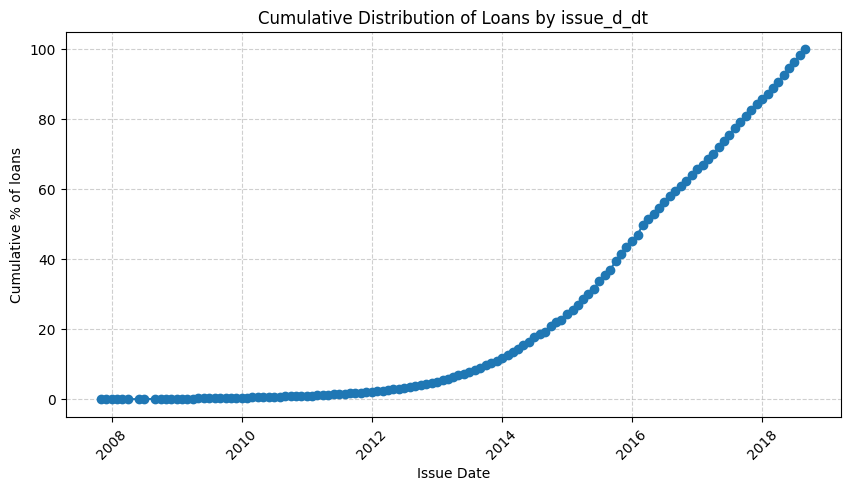

In [ ]:
# Add cumulative percentage
counts["cum_pct"] = counts["pct"].cumsum()

# Plot cumulative distribution
plt.figure(figsize=(10,5))
plt.plot(counts["issue_d_dt"], counts["cum_pct"], marker="o")
plt.title("Cumulative Distribution of Loans by issue_d_dt")
plt.xlabel("Issue Date")
plt.ylabel("Cumulative % of loans")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

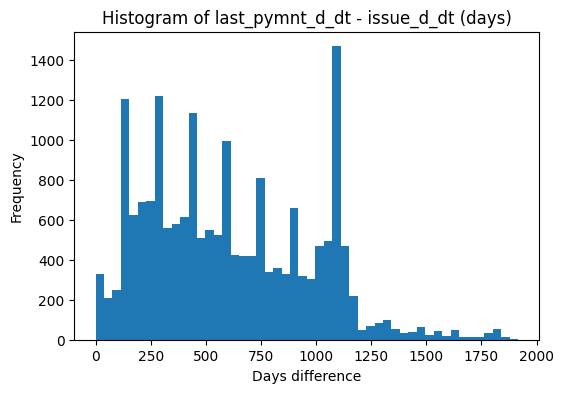

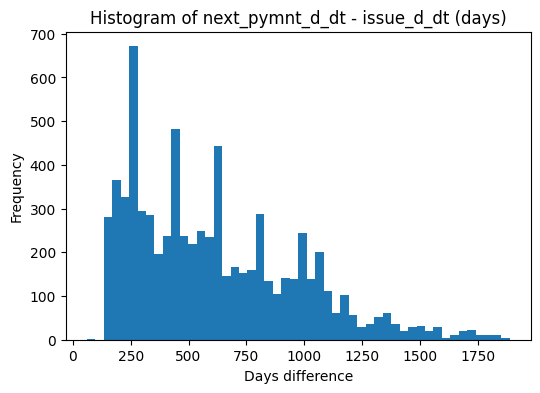

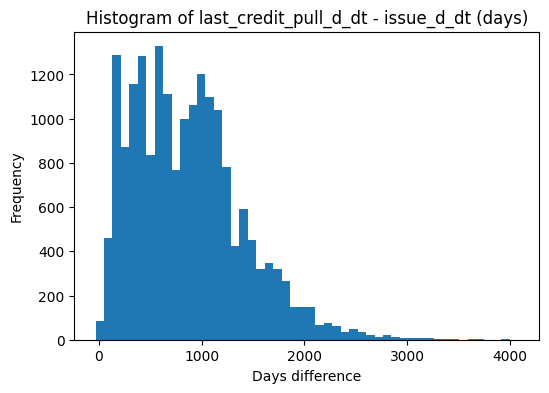

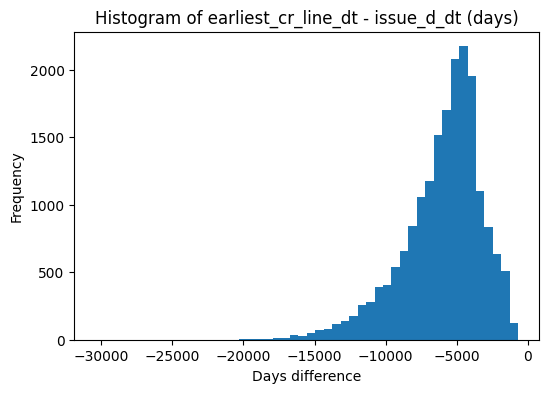

In [ ]:
# Pick the columns you want to compare against issue_d_dt
compare_cols = ["last_pymnt_d_dt", "next_pymnt_d_dt", "last_credit_pull_d_dt", "earliest_cr_line_dt"]

for col in compare_cols:
    if col in df.columns:
        # Compute difference in days (can change to months if you prefer)
        diff_days = (df[col] - df["issue_d_dt"]).dt.days

        # Drop missing values
        diff_days = diff_days.dropna()

        # Plot histogram
        plt.figure(figsize=(6,4))
        plt.hist(diff_days, bins=50)
        plt.title(f"Histogram of {col} - issue_d_dt (days)")
        plt.xlabel("Days difference")
        plt.ylabel("Frequency")
        plt.show()


### Investigate the spike in last_pymnt_d_dt - issue_d_dt

In [ ]:
# Count frequency of last_pymnt_d_dt values
counts = (
    df["last_pymnt_d_dt"]
    .value_counts(dropna=False)
    .sort_index()
)

counts_pct = (counts / len(df) * 100).round(2)

# Top 5 spike months
spike_months = counts_pct.sort_values(ascending=False).head(5)
print(spike_months)


last_pymnt_d_dt
2019-01-01    37.86
2018-07-01     1.88
2018-12-01     1.88
2018-03-01     1.87
2018-10-01     1.87
Name: count, dtype: float64


It looks like Jan-2019 is the timing of the last data in this data set...

## Analysis of Loan Amount vs. Funded vs. Invested

In [ ]:
def classify_relationship(row):
    a, f, i = row["loan_amnt"], row["funded_amnt"], row["funded_amnt_inv"]
    if pd.isna(a) or pd.isna(f) or pd.isna(i):
        return "missing"
    return f"loan={a}, funded={f}, inv={i}"

# Instead of returning exact numbers, we reduce to a pattern:
def classify_relationship(row):
    a, f, i = row["loan_amnt"], row["funded_amnt"], row["funded_amnt_inv"]
    if pd.isna(a) or pd.isna(f) or pd.isna(i):
        return "missing"
    if a == f == i:
        return "all equal"
    if a == f and f > i:
        return "loan=funded > investors"
    if a > f == i:
        return "loan > funded=investors"
    if a > f > i:
        return "loan > funded > investors"
    if a == f and i > f:  # shouldn’t happen but safe check
        return "investors > loan=funded"
    return "other pattern"

# Apply classification
cats = df.apply(classify_relationship, axis=1)

summary = (
    cats.value_counts()
        .to_frame("count")
        .assign(pct=lambda s: (s["count"] / len(df) * 100).round(2))
        .reset_index()
        .rename(columns={"index": "relationship"})
)

print(summary)


                relationship  count    pct
0                  all equal  17628  92.91
1    loan=funded > investors   1323   6.97
2  loan > funded > investors     18   0.09
3    loan > funded=investors      5   0.03


In [ ]:
# Select rows where loan_amnt is greater than funded_amnt
mask = df["loan_amnt"] > df["funded_amnt"]

# Or just peek at the first few
print(df[mask].head())



      loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  installment grade sub_grade                          emp_title emp_length home_ownership  annual_inc verification_status   issue_d  loan_status pymnt_plan                                               desc             purpose  \
267     35000.0      23950.0         23925.00   60 months     10.99       520.62     B        B3  Employment Development Department  10+ years       MORTGAGE    48712.44            Verified  Jul-2011   Fully Paid          n    Borrower added on 07/10/11 > I plan on using...      small_business   
534     22500.0      14025.0         14025.00   36 months      8.90       445.34     A        A5                 Henry Schein, Inc.  10+ years           RENT   185000.00        Not Verified  Jul-2012   Fully Paid          n    Borrower added on 06/14/12 > Thank you for c...  debt_consolidation   
2797     7500.0       3600.0          1969.97   36 months     11.34       118.44     C        C2          

# Target Engineering

In [ ]:
# Generate the target column, where the loan status is charged off
df['target'] = (df['loan_status'] == 'Charged Off').astype(int)

In [ ]:
pd.crosstab(df['issue_d_dt'], df['target']).head(30)

target,0,1
issue_d_dt,,
2007-11-01,1,0
2007-12-01,1,0
2008-01-01,4,0
2008-02-01,3,0
2008-03-01,3,1
2008-04-01,2,0
2008-06-01,1,0
2008-07-01,1,0
2008-09-01,2,0


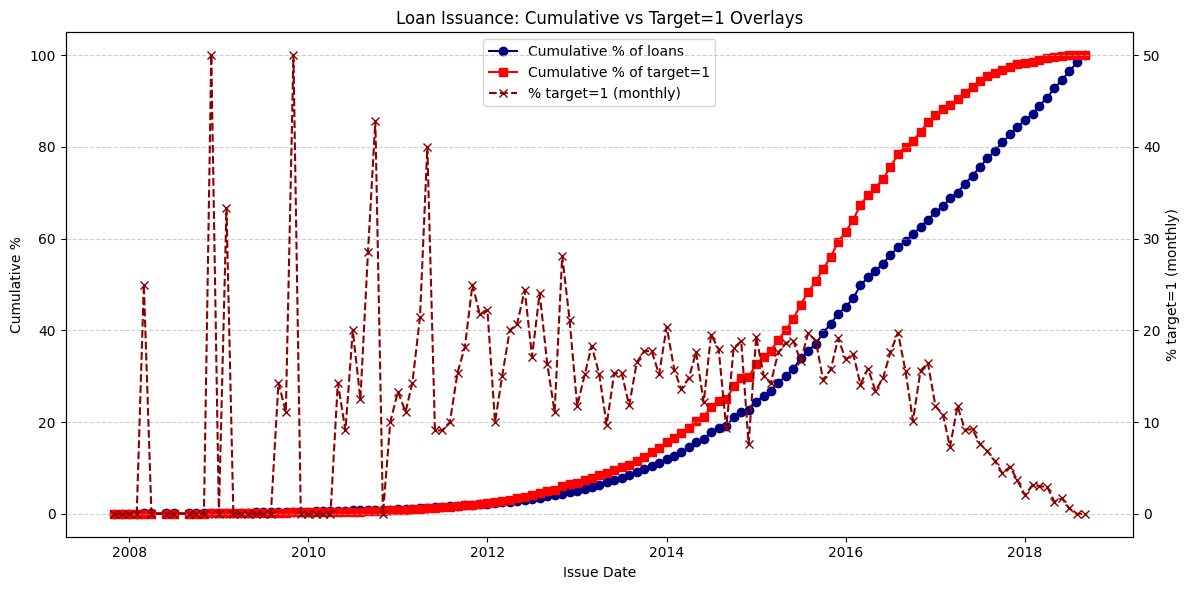

In [ ]:
# Aggregate by month
monthly = (
    df.groupby("issue_d_dt")
      .agg(
          total=("target", "size"),
          target1=("target", "sum")
      )
      .reset_index()
      .sort_values("issue_d_dt")
)

# Percentages
monthly["pct_target1"] = monthly["target1"] / monthly["total"] * 100
monthly["cum_pct_total"] = monthly["total"].cumsum() / monthly["total"].sum() * 100
monthly["cum_pct_target1"] = monthly["target1"].cumsum() / monthly["target1"].sum() * 100

# Plot
fig, ax1 = plt.subplots(figsize=(12,6))

# Lines for cumulative % of loans and target=1
ax1.plot(monthly["issue_d_dt"], monthly["cum_pct_total"], color="navy", marker="o", label="Cumulative % of loans")
ax1.plot(monthly["issue_d_dt"], monthly["cum_pct_target1"], color="red", marker="s", label="Cumulative % of target=1")

# Secondary axis for monthly % target=1
ax2 = ax1.twinx()
ax2.plot(monthly["issue_d_dt"], monthly["pct_target1"], color="darkred", marker="x", linestyle="--", label="% target=1 (monthly)")

# Labels and titles
ax1.set_title("Loan Issuance: Cumulative vs Target=1 Overlays")
ax1.set_xlabel("Issue Date")
ax1.set_ylabel("Cumulative %")
ax2.set_ylabel("% target=1 (monthly)")

# Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper center")

plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


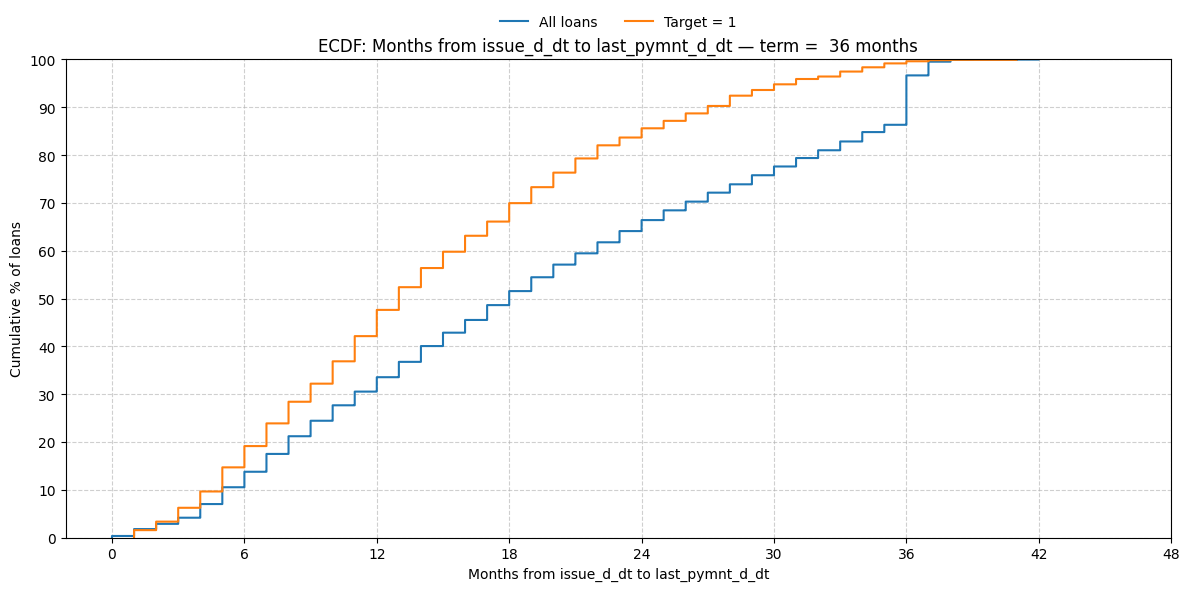

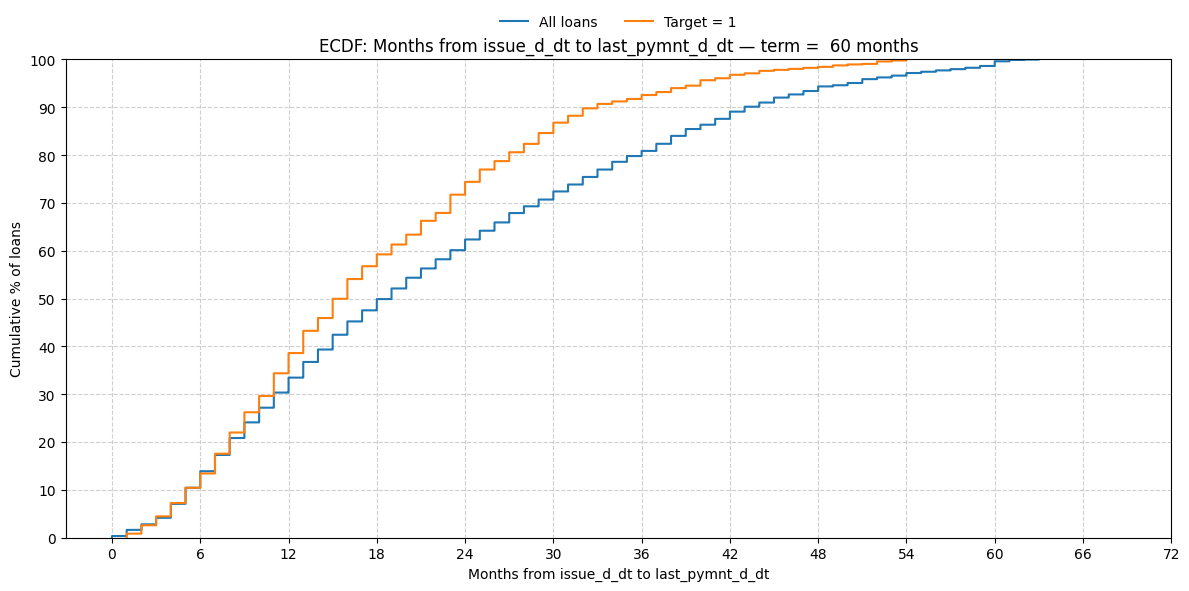

In [ ]:
# --- Helpers
def ecdf(series):
    s = np.asarray(series.dropna())
    if s.size == 0:
        return np.array([]), np.array([])
    s = np.sort(s)
    y = np.arange(1, s.size + 1) / s.size * 100.0
    return s, y

def month_diff(later, earlier):
    # integer months via period ordinals avoids MonthEnd offset issues
    return later.dt.to_period("M").astype(int) - earlier.dt.to_period("M").astype(int)

# --- Ensure required columns exist
required = {"issue_d_dt", "last_pymnt_d_dt", "term", "target"}
missing = required - set(df.columns)
if missing:
    raise KeyError(f"Missing required columns: {missing}")

# --- Iterate each term (e.g., '36 months', '60 months', etc.)
for term_val in sorted(df["term"].dropna().unique(), key=lambda s: str(s)):
    sub = df[df["term"] == term_val].copy()

    # Filter rows that have both dates
    mask_all = sub["last_pymnt_d_dt"].notna() & sub["issue_d_dt"].notna()
    if not mask_all.any():
        print(f"[skip] term={term_val}: no rows with both dates.")
        continue

    # Month diffs
    all_months = month_diff(sub.loc[mask_all, "last_pymnt_d_dt"], sub.loc[mask_all, "issue_d_dt"])

    mask_t1 = mask_all & (sub["target"] == 1)
    t1_months = month_diff(sub.loc[mask_t1, "last_pymnt_d_dt"], sub.loc[mask_t1, "issue_d_dt"])

    # Build ECDFs
    x_all, y_all = ecdf(all_months)
    x_t1,  y_t1  = ecdf(t1_months)

    # Skip if nothing to plot
    if x_all.size == 0 and x_t1.size == 0:
        print(f"[skip] term={term_val}: no valid diffs.")
        continue

    # Plot one figure per term
    fig, ax = plt.subplots(figsize=(12,6))

    if x_all.size:
        ax.step(x_all, y_all, where="post", label="All loans")
    if x_t1.size:
        ax.step(x_t1,  y_t1,  where="post", label="Target = 1")

    ax.set_title(f"ECDF: Months from issue_d_dt to last_pymnt_d_dt — term = {term_val}")
    ax.set_xlabel("Months from issue_d_dt to last_pymnt_d_dt")
    ax.set_ylabel("Cumulative % of loans")
    ax.set_yticks(np.linspace(0, 100, 11))
    ax.set_ylim(0, 100)

    # 6-month x-axis ticks
    # Use current x-limits after plotting to derive a sensible max
    xmin, xmax = ax.get_xlim()
    # ensure start at 0 for readability
    xmin = 0 if np.isfinite(xmin) else 0
    xmax = max(6, xmax) if np.isfinite(xmax) else 6
    xticks = np.arange(0, xmax + 6, 6)
    ax.set_xticks(xticks)

    # Legend at top center
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.12), ncol=2, frameon=False)

    ax.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    plt.show()

# Feature Engineering Earliest credit line

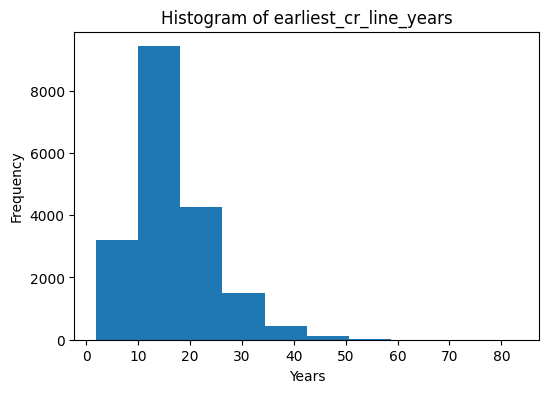

In [ ]:
# Engineer a new feature for earliest_cr_line
df["earliest_cr_line_years"] = (df["issue_d_dt"].dt.year - df["earliest_cr_line_dt"].dt.year) + (df["issue_d_dt"].dt.month - df["earliest_cr_line_dt"].dt.month) / 12.0
# Plot histogram
plt.figure(figsize=(6,4))
plt.hist(df["earliest_cr_line_years"], bins=10)
plt.title(f"Histogram of earliest_cr_line_years")
plt.xlabel("Years")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Feature idea: installment / annual_inc?  ... ability to pay?
#feature showing average balance to income ratio
df['bal_to_inc'] = df['tot_cur_bal'] / df['annual_inc']

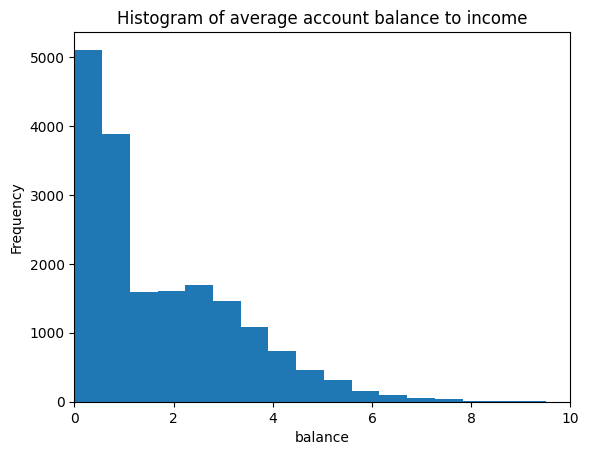

In [ ]:
plt.hist(df["bal_to_inc"], bins=20)
plt.title(f"Histogram of toal account balance to income")
plt.xlabel("balance")
plt.xlim(0,10)
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Feature idea: installment / annual_inc?  ... ability to pay
df['installment_to_inc'] = df['installment'] / df['annual_inc']

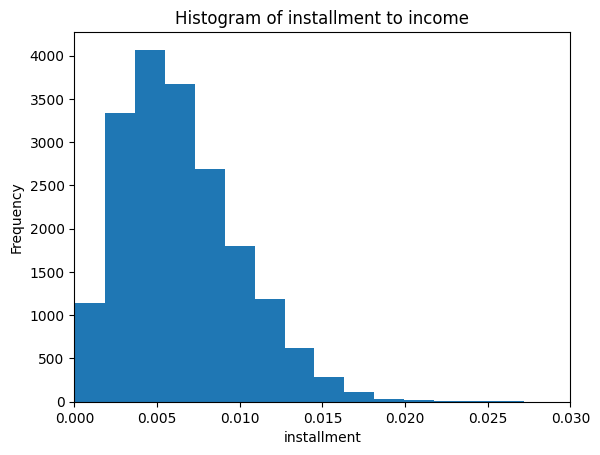

In [ ]:
plt.hist(df["installment_to_inc"], bins=20)
plt.title(f"Histogram of installment to income")
plt.xlabel("installment")
plt.xlim(0,.03
         )
plt.ylabel("Frequency")
plt.show()

In [ ]:
#feature indicating if the borrower was never delinquent  or had a public record
df['never_delinquent'] = (df['mths_since_last_delinq'].isnull()) & (df['mths_since_last_record'].isnull())
print(df['never_delinquent'].value_counts())

never_delinquent
False    11004
True      7970
Name: count, dtype: int64


## Investigating relationship of Target variable and Issuance Date to determine where to Trim the Set


<Axes: xlabel='issue_d_dt'>

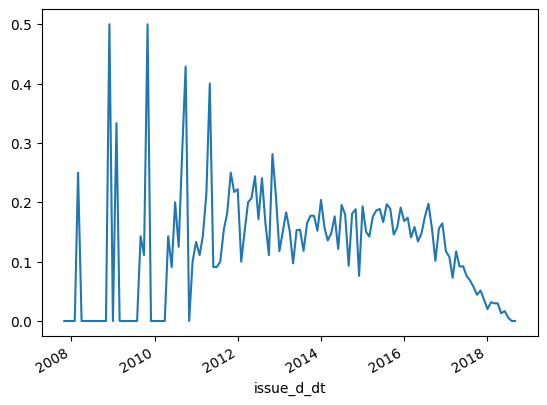

In [ ]:
#plotting target ratio by issue_d
df.groupby('issue_d_dt')['target'].mean().plot()

In [ ]:
#filtering the dataset for loans with issue_d_date before January 1 2017, because there is a clear drop off in the charge off rate past 2017, likely because we aren't seeing those loans come close to maturity
df = df[df['issue_d_dt'] < '2017-01-01']

# TODO: Filter / Exclude...

In [ ]:
# Any columns created above (for temporary use)
temp_use_columns = ["issue_d_dt", "last_pymnt_d_dt", "next_pymnt_d_dt", "last_credit_pull_d_dt", "earliest_cr_line_dt"]
# Remove columns that exist in the DataFrame
cols_to_drop = [col for col in temp_use_columns if col in df.columns]
df = df.drop(columns=cols_to_drop)

# Loan info
loan_info_columns = ["loan_amnt", "funded_amnt", "funded_amnt_inv", "int_rate", "installment", "issue_d"]
cols_to_drop = [col for col in loan_info_columns if col in df.columns]
df = df.drop(columns=cols_to_drop)

# Post-loan info
post_loan_info = ["loan_status", "out_prncp", "out_prncp_inv", "total_pymnt", "total_pymnt_inv",
"total_rec_prncp", "total_rec_int", "total_rec_late_fee", "recoveries",
"collection_recovery_fee", "last_pymnt_d", "last_pymnt_amnt",
"next_pymnt_d", "last_credit_pull_d","last_fico_range_high","last_fico_range_low"]
cols_to_drop = [col for col in post_loan_info if col in df.columns]
df = df.drop(columns=cols_to_drop)

In [ ]:
print(df.head())

         term grade sub_grade                           emp_title emp_length home_ownership  annual_inc verification_status pymnt_plan  desc             purpose                    title zip_code addr_state    dti  delinq_2yrs earliest_cr_line  fico_range_low  fico_range_high  inq_last_6mths  \
1   36 months     E        E5                 Corrections Officer  10+ years           RENT     65878.0            Verified          n  None  debt_consolidation       Debt consolidation    149xx         NY   7.91          0.0         Jun-2000           730.0            734.0             3.0   
3   60 months     B        B5                 Assistant Principal    3 years       MORTGAGE     64000.0        Not Verified          n  None  debt_consolidation       Debt consolidation    856xx         AZ  14.34          0.0         Jul-2000           740.0            744.0             0.0   
4   60 months     E        E4                 Corrections Officer  10+ years           RENT     73000.0            

In [ ]:
#dropping emp_title
df = df.drop(columns=['emp_title'])

In [ ]:
#checking the initial_list_status value counts
df['initial_list_status'].value_counts()

,count
initial_list_status,
w,7079
f,5095


In [ ]:
#checking term value counts
df['term'].value_counts()

,count
term,
36 months,8683
60 months,3491


In [ ]:
#checking grade value counts
df['grade'].value_counts()

,count
grade,
B,3583
C,3523
A,2059
D,1759
E,886
F,279
G,85


# Feature Engineering 'Grade' and 'Subgrade' Variabeles

In [ ]:
import itertools

#converting grade and subgrade to a single numeric scale:

grades = list("ABCDEFG")
subgrades = [str(i) for i in range(1,6)]
full_order = [g + s for g, s in itertools.product(grades, subgrades)]

# Create mapping dict: {'A1':1, 'A2':2, ..., 'G5':35}
subgrade_map = {sg: i for i, sg in enumerate(full_order, 1)}

df['sub_grade_num'] = df['sub_grade'].map(subgrade_map)

In [ ]:
print(df['sub_grade_num'].value_counts())

sub_grade_num
9     769
12    766
11    765
10    751
8     730
14    724
7     704
13    659
6     629
15    609
5     571
4     440
16    431
17    404
1     400
2     330
18    322
19    321
3     318
20    281
21    241
22    193
23    171
24    152
25    129
26     93
28     62
27     50
29     43
30     31
32     27
31     24
33     14
34     12
35      8
Name: count, dtype: int64


In [ ]:
#dropping grade and sub_grade variables
df = df.drop(columns=['grade', 'sub_grade'])

## Adjusting emp_length

In [ ]:
#checking emp_length values
df['emp_length'].value_counts()


,count
emp_length,
10+ years,4149
2 years,1107
3 years,933
< 1 year,924
1 year,781
5 years,767
4 years,703
8 years,604
6 years,542


In [ ]:
#converting empl_length to numeric scale
emp_length_map = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}

df['emp_length_num'] = df['emp_length'].map(emp_length_map)


In [ ]:
df = df.drop(columns=['emp_length'])

In [ ]:
#dropping fico range high, as its correlated to fico range low
df = df.drop(columns = ['fico_range_high'])
#dropping term, as this reflects underwriting decisions.
df = df.drop(columns=['term'])

In [ ]:
print(df['home_ownership'].value_counts())

home_ownership
MORTGAGE    6003
RENT        4818
OWN         1350
ANY            2
OTHER          1
Name: count, dtype: int64


In [ ]:
#dropping values of home ownership for 'any' and 'other'
df = df[df['home_ownership'] != 'ANY']
df = df[df['home_ownership'] != 'OTHER']

In [ ]:
#checking the value counts of verification status
df['verification_status'].value_counts()

,count
verification_status,
Source Verified,4727
Verified,3891
Not Verified,3553


In [ ]:
print(df['pymnt_plan'].value_counts())

pymnt_plan
n    12168
y        3
Name: count, dtype: int64


## Dropping Several Variables

In [ ]:
#dropping paymnt_plan variable
df = df.drop(columns=['pymnt_plan'])

In [ ]:
print(df['purpose'].value_counts())

purpose
debt_consolidation    7160
credit_card           2708
home_improvement       731
other                  693
major_purchase         257
small_business         143
medical                131
car                    125
moving                  72
vacation                60
house                   56
wedding                 18
renewable_energy        11
educational              6
Name: count, dtype: int64


In [ ]:
# dropping zip code variable
df = df.drop(columns=['zip_code'])

In [ ]:
#dropping 'addr_state' variable
df = df.drop(columns=['addr_state'])

In [ ]:
print(df.head())

  home_ownership  annual_inc verification_status  desc             purpose                    title    dti  delinq_2yrs earliest_cr_line  fico_range_low  inq_last_6mths  mths_since_last_delinq  mths_since_last_record  open_acc  pub_rec  revol_bal  revol_util  total_acc initial_list_status  \
1           RENT     65878.0            Verified  None  debt_consolidation       Debt consolidation   7.91          0.0         Jun-2000           730.0             3.0                    25.0                     NaN       9.0      0.0     3671.0        17.9       17.0                   w   
3       MORTGAGE     64000.0        Not Verified  None  debt_consolidation       Debt consolidation  14.34          0.0         Jul-2000           740.0             0.0                     NaN                     NaN       8.0      0.0    18485.0        65.8       16.0                   f   
4           RENT     73000.0            Verified  None  debt_consolidation       Debt consolidation  21.17          0.0  

In [ ]:
print(df['inq_fi'].value_counts())

inq_fi
0.0     2172
1.0      941
2.0      498
3.0      237
4.0      116
5.0       72
6.0       34
7.0       15
8.0        8
9.0        7
10.0       5
16.0       1
13.0       1
12.0       1
11.0       1
14.0       1
Name: count, dtype: int64


## Null Treatment

In [ ]:
#converting nulls for df['inq_fi] to 0 and adding a flag
df['inq_fi_missing'] = df['inq_fi'].isna().astype(int)
df['inq_fi'] = df['inq_fi'].fillna(0)

In [ ]:
df['total_cu_tl_missing'] = df['total_cu_tl'].isna().astype(int)
df['total_cu_tl'] = df['total_cu_tl'].fillna(0)

In [ ]:
df['inq_last_12m_missing'] = df['inq_last_12m'].isna().astype(int)
df['inq_last_12m'] = df['inq_last_12m'].fillna(0)

In [ ]:
#investigating null counts per feature
df.isnull().sum()

,0
home_ownership,0
annual_inc,0
verification_status,0
desc,10992
purpose,0
title,215
dti,0
delinq_2yrs,0
earliest_cr_line,0
fico_range_low,0


In [ ]:
missing_credit_field_cols = ['tot_coll_amt', 'tot_cur_bal','mort_acc', 'total_rev_hi_lim', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m','num_tl_op_past_12m', 'percent_bc_gt_75', 'pub_rec_bankruptcies','tot_hi_cred_lim', 'total_bal_ex_mort','total_bc_limit','total_il_high_credit_limit', 'bal_to_inc', 'emp_length_num']
for col in missing_credit_field_cols:
    df[col + '_missing'] = df[col].isna().astype(int)
    df[col] = df[col].fillna(0)

In [ ]:
print(df['pct_tl_nvr_dlq'].value_counts())

pct_tl_nvr_dlq
100.0    5632
95.0      196
90.0      164
96.0      138
92.9      121
93.3      118
88.9      115
85.7      115
92.3      115
90.9      115
91.7      113
87.5      108
80.0      108
94.1      107
94.4      107
95.2      106
95.5      100
83.3       96
97.0       96
93.7       95
95.7       88
94.7       88
92.0       81
96.2       73
95.8       72
94.0       72
97.1       66
96.3       64
88.2       63
93.0       62
96.6       60
75.0       59
87.0       58
96.4       54
96.8       53
85.0       52
97.4       50
88.0       49
89.5       49
86.7       47
96.7       47
84.6       47
96.9       47
91.3       45
90.5       45
93.1       40
98.0       39
88.5       37
66.7       37
93.5       36
77.8       35
91.0       35
92.6       35
81.0       34
81.8       34
86.4       34
81.2       33
82.4       32
97.6       32
89.7       32
84.2       31
97.3       30
97.7       30
97.8       29
84.0       28
86.0       28
94.6       26
94.3       26
78.6       25
97.2       24
78.9 

In [ ]:
df['pct_tl_nvr_dlq_missing'] = df['pct_tl_nvr_dlq'].isna().astype(int)
df['pct_tl_nvr_dlq'] = df['pct_tl_nvr_dlq'].fillna(100.0)

In [ ]:
df.isnull().sum()

,0
home_ownership,0
annual_inc,0
verification_status,0
desc,10992
purpose,0
title,215
dti,0
delinq_2yrs,0
earliest_cr_line,0
fico_range_low,0


In [ ]:
print(df['open_rv_24m'].value_counts())

open_rv_24m
1.0     815
2.0     754
3.0     617
0.0     575
4.0     434
5.0     314
6.0     222
7.0     142
8.0      88
9.0      47
10.0     33
11.0     22
12.0     11
13.0     11
16.0      6
15.0      6
14.0      6
19.0      2
17.0      2
33.0      1
24.0      1
22.0      1
Name: count, dtype: int64


In [ ]:
more_missing_cols = [
    "open_acc_6m",
    "open_act_il",
    "open_il_12m",
    "open_il_24m",
    "mths_since_rcnt_il",
    "total_bal_il",
    "il_util",
    "open_rv_12m",
    "open_rv_24m",
    "max_bal_bc",
    "all_util",
    "acc_open_past_24mths",
    "avg_cur_bal",
    "bc_util",
    'mort_acc',
    'num_accts_ever_120_pd'
]

# Create a binary missing flag for each column
for c in more_missing_cols:
    df[f"{c}_missing"] = df[c].isna().astype(int)


df[more_missing_cols] = df[more_missing_cols].fillna(0)

In [ ]:
df.isnull().sum()

,0
home_ownership,0
annual_inc,0
verification_status,0
desc,10992
purpose,0
title,215
dti,0
delinq_2yrs,0
earliest_cr_line,0
fico_range_low,0


## Text Analysis

In [ ]:
#text analysis of the 'desc' field
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def clean_text(text_series):
    # Combine all text, remove NaNs, lowercase
    text = " ".join(text_series.dropna().astype(str).str.lower())
    return text

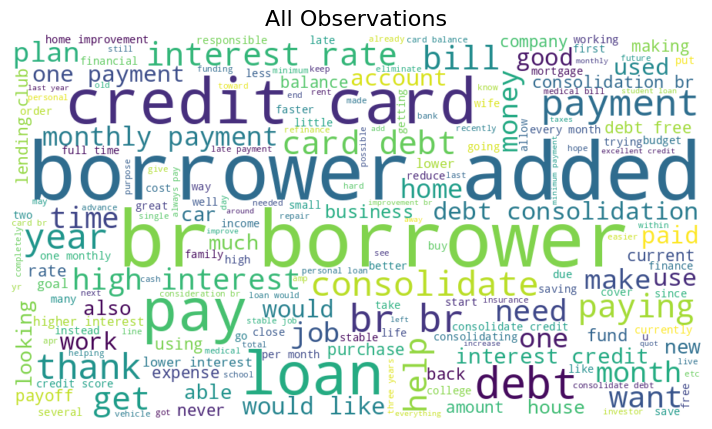

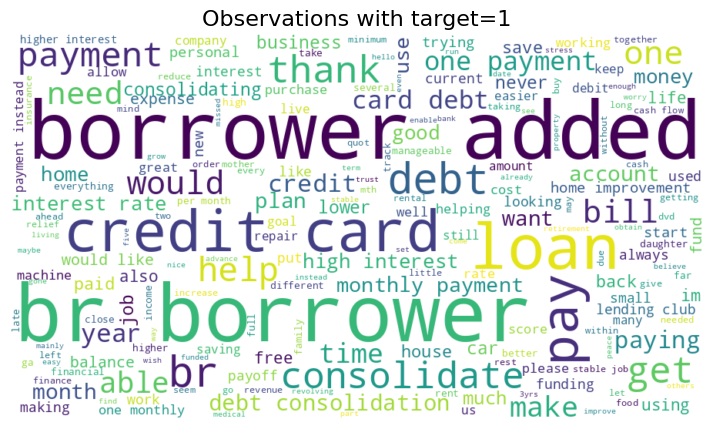

In [ ]:
def plot_wordcloud(text, title):
    wc = WordCloud(width=900, height=500,
                   background_color='white',
                   stopwords=stop_words,
                   colormap='viridis').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

# All observations
plot_wordcloud(clean_text(df['desc']), "All Observations")

# Only target == 1
plot_wordcloud(clean_text(df.loc[df['target'] == 1, 'desc']),
               "Observations with target=1")

In [ ]:
from collections import Counter
import re

def word_frequencies(text_series, n=25):
    text = clean_text(text_series)
    # remove non-alphabetic chars and split
    words = re.findall(r'\b[a-z]+\b', text)
    words = [w for w in words if w not in stop_words]
    return Counter(words).most_common(n)

# Top words overall
print("Top words overall:", word_frequencies(df['desc'], 25))

# Top words when target=1
print("Top words target=1:", word_frequencies(df.loc[df['target']==1, 'desc'], 25))

Top words overall: [('br', 1839), ('borrower', 1393), ('added', 1381), ('credit', 941), ('loan', 722), ('pay', 703), ('debt', 647), ('cards', 437), ('card', 418), ('interest', 374), ('payment', 297), ('consolidate', 269), ('one', 257), ('years', 230), ('would', 216), ('payments', 203), ('monthly', 201), ('get', 198), ('rate', 186), ('high', 186), ('paying', 185), ('time', 176), ('help', 167), ('bills', 160), ('home', 153)]
Top words target=1: [('br', 283), ('borrower', 234), ('added', 232), ('credit', 130), ('loan', 125), ('debt', 89), ('pay', 88), ('cards', 68), ('one', 65), ('payment', 56), ('card', 53), ('interest', 46), ('would', 45), ('consolidate', 44), ('get', 43), ('help', 37), ('need', 32), ('thank', 31), ('bills', 30), ('payments', 29), ('able', 29), ('make', 27), ('time', 25), ('monthly', 23), ('home', 23)]


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [ ]:
df['desc'] = df['desc'].fillna("")

tfidf = TfidfVectorizer(
    lowercase=True,
    stop_words='english',   # filter common English stopwords
    min_df=5                # ignore words appearing in <5 docs (tune as needed)
)

X = tfidf.fit_transform(df['desc'])
y = df['target']

In [ ]:
log_reg = LogisticRegression(max_iter=1000, penalty="l2")
log_reg.fit(X, y)

LogisticRegression(max_iter=1000)

In [ ]:
feature_names = np.array(tfidf.get_feature_names_out())
coef = log_reg.coef_[0]

# Top 20 terms most associated with target=1
top_pos_idx = np.argsort(coef)[-20:][::-1]
top_pos_terms = feature_names[top_pos_idx]
top_pos_scores = coef[top_pos_idx]

for term, score in zip(top_pos_terms, top_pos_scores):
    print(f"{term:20s}  {score:.4f}")

able                  1.7133
need                  1.1659
debit                 1.1000
consolidating         1.0805
23                    1.0443
payment               0.9825
im                    0.9394
11                    0.9085
life                  0.8471
accounts              0.8431
20                    0.8159
27                    0.7553
thank                 0.6882
12                    0.6759
make                  0.6659
using                 0.6598
obtain                0.6102
renovations           0.6070
rest                  0.5401
25                    0.5365


In [ ]:
top_neg_idx = np.argsort(coef)[:20]
for term, score in zip(feature_names[top_neg_idx], coef[top_neg_idx]):
    print(f"{term:20s}  {score:.4f}")

years                 -1.2584
rate                  -1.2332
09                    -1.0809
03                    -1.0021
pay                   -0.9752
money                 -0.9172
currently             -0.9138
14                    -0.9019
want                  -0.8957
high                  -0.8057
year                  -0.6923
19                    -0.6786
consideration         -0.6503
work                  -0.6314
months                -0.6022
budget                -0.5659
kitchen               -0.5656
02                    -0.5506
used                  -0.5493
vacation              -0.5385


In [ ]:
keywords = ["able", "need", "consolidating", "debit"]

In [ ]:
import re

# Pre-compile a regex for efficiency
pattern = r"(" + "|".join(re.escape(k) for k in keywords) + r")"

df["desc_flag"] = (
    df["desc"]
      .fillna("")                      # handle missing descriptions
      .str.lower()                     # case-insensitive
      .str.contains(pattern, regex=True)
      .astype(int)
)

/tmp/ipython-input-931519339.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  .str.contains(pattern, regex=True)
/tmp/ipython-input-931519339.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["desc_flag"] = (


In [ ]:
#evaluating the results of the text flag
print(df['target'].value_counts())
print(df['desc_flag'].value_counts())

target
0    10175
1     1996
Name: count, dtype: int64
desc_flag
0    11860
1      311
Name: count, dtype: int64


In [ ]:
flagged = df[df['desc_flag'] == 1]
print(flagged['target'].value_counts())

target
0    250
1     61
Name: count, dtype: int64


In [ ]:
#flag not worthwhile
df = df.drop(columns=['desc', 'desc_flag'])


In [ ]:
df = df.drop(columns = ['title'])

In [ ]:
print(df.head())

  home_ownership  annual_inc verification_status             purpose    dti  delinq_2yrs earliest_cr_line  fico_range_low  inq_last_6mths  mths_since_last_delinq  mths_since_last_record  open_acc  pub_rec  revol_bal  revol_util  total_acc initial_list_status  collections_12_mths_ex_med  \
1           RENT     65878.0            Verified  debt_consolidation   7.91          0.0         Jun-2000           730.0             3.0                    25.0                     NaN       9.0      0.0     3671.0        17.9       17.0                   w                         0.0   
3       MORTGAGE     64000.0        Not Verified  debt_consolidation  14.34          0.0         Jul-2000           740.0             0.0                     NaN                     NaN       8.0      0.0    18485.0        65.8       16.0                   f                         0.0   
4           RENT     73000.0            Verified  debt_consolidation  21.17          0.0         Dec-1994           690.0         

In [ ]:
df = df.drop(columns = ['earliest_cr_line'])

## Model Prep for XG boost

In [ ]:
#copying df
df_xgb = df.copy()

In [ ]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns
print(cat_cols.tolist())

['home_ownership', 'verification_status', 'purpose', 'initial_list_status']


In [ ]:
#no need to one-hot encode, as XBG has a paramter which enables this to happen automatically

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score


In [ ]:
cat_cols = df_xgb.select_dtypes(include="object").columns
df_xgb[cat_cols] = df_xgb[cat_cols].astype("category")

In [ ]:
# Split X / y
y = df_xgb["target"]
X = df_xgb.drop(columns=["target"])

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

## XGBoost Pipeline

In [ ]:
# 1) Build a pipeline
# ---------------------------
# We keep this simple: no ColumnTransformer so pandas dtypes are preserved.
pipe = Pipeline(steps=[
    ("model", XGBClassifier(
        tree_method="hist",          # required for categorical support
        enable_categorical=True,
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1,
    ))
])

# ---------------------------
# 2) Hyperparameter grid
# ---------------------------
param_distributions = {
    "model__n_estimators":      [100, 150, 200, 250],     # fewer trees during search
    "model__max_depth":         [3, 4, 5, 6, 8],
    "model__min_child_weight":  [1, 2, 3, 5],
    "model__subsample":         [0.7, 0.85, 1.0],
    "model__colsample_bytree":  [0.6, 0.8, 1.0],
    "model__gamma":             [0, 0.5, 1, 2],
    "model__reg_alpha":         [0, 0.1, 0.5, 1.0],
    "model__reg_lambda":        [0.5, 1.0, 3.0, 5.0],
    "model__learning_rate":     [0.02, 0.05, 0.1]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rand = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=60,                 # sample 60 candidate combos (tune as desired)
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42,
    refit=True                 # best model refit on full data automatically
)

rand.fit(X, y)

print("Best CV AUC:", rand.best_score_)
print("Best params:\n", rand.best_params_)

best_model = rand.best_estimator_

# ---------------------------
# 3) Optional: Final refit with more estimators
#    (same best params, just increase trees)
# ---------------------------
final_params = best_model.get_params()
# bump trees for the final model
final_params["model__n_estimators"] = 600

final_model = Pipeline(steps=[
    ("model", XGBClassifier(
        **{
            k.replace("model__", ""): v
            for k, v in final_params.items()
            if k.startswith("model__")
        }
    ))
])

final_model.fit(X, y)

# Quick training AUC (optimistic; use holdout/CV for real eval)
y_hat = final_model.predict_proba(X)[:, 1]
print("Training AUC (optimistic):", roc_auc_score(y, y_hat))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best CV AUC: 0.7018002644818434
Best params:
 {'model__subsample': 0.7, 'model__reg_lambda': 3.0, 'model__reg_alpha': 0.1, 'model__n_estimators': 250, 'model__min_child_weight': 3, 'model__max_depth': 6, 'model__learning_rate': 0.02, 'model__gamma': 0.5, 'model__colsample_bytree': 1.0}
Training AUC (optimistic): 0.9671643040380514


In [ ]:
#feature importance
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split



Validation AUC: 0.6939266141778807
                   feature  importance_mean  importance_std
0            sub_grade_num         0.094500        0.013956
1       installment_to_inc         0.009680        0.002771
2                      dti         0.007931        0.001407
3                  purpose         0.005942        0.002006
4           fico_range_low         0.005285        0.002464
5     acc_open_past_24mths         0.004751        0.002190
6      verification_status         0.003248        0.001671
7           total_bc_limit         0.001974        0.000940
8    mths_since_recent_inq         0.001949        0.001658
9           bc_open_to_buy         0.001888        0.000864
10          num_actv_bc_tl         0.001769        0.000975
11    mths_since_recent_bc         0.001743        0.000896
12               total_acc         0.001489        0.000640
13        percent_bc_gt_75         0.001331        0.000840
14           num_op_rev_tl         0.001311        0.000692
15   

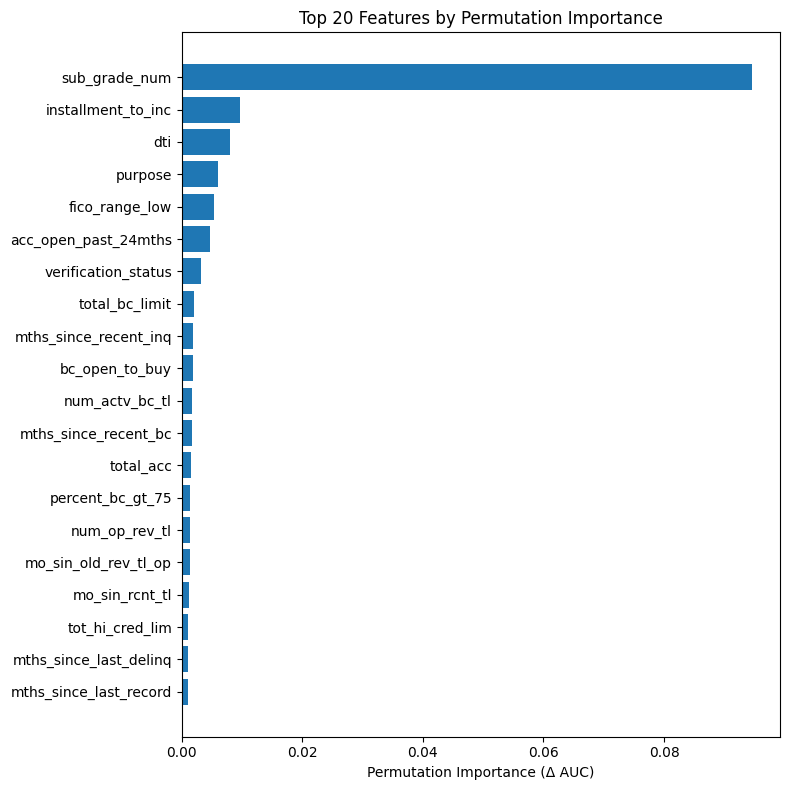

In [ ]:
at_cols = df_xgb.select_dtypes(include="object").columns
df_xgb[cat_cols] = df_xgb[cat_cols].astype("category")

y = df_xgb["target"]
X = df_xgb.drop(columns=["target"])

# 1) Hold-out split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 2) Refit best model on training split (even if Grid/RandomizedSearch already refit)
best_model.fit(X_train, y_train)

# (Optional sanity check metric)
val_proba = best_model.predict_proba(X_val)[:, 1]
print("Validation AUC:", roc_auc_score(y_val, val_proba))

# 3) Permutation importance on the hold-out
r = permutation_importance(
    estimator=best_model,
    X=X_val,
    y=y_val,
    n_repeats=20,          # increase for more stable estimates
    scoring="roc_auc",     # use your task metric
    random_state=42,
    n_jobs=-1
)

# 4) Assemble a tidy DataFrame
imp_df = (
    pd.DataFrame({
        "feature": X_val.columns,
        "importance_mean": r.importances_mean,
        "importance_std": r.importances_std
    })
    .sort_values("importance_mean", ascending=False)
    .reset_index(drop=True)
)

print(imp_df.head(25))  # top 25 features

# (Optional) Quick bar plot of top 20
import matplotlib.pyplot as plt

topn = 20
ax = imp_df.head(topn).iloc[::-1]  # reverse for horizontal plot
plt.figure(figsize=(8, 8))
plt.barh(ax["feature"], ax["importance_mean"])
plt.xlabel("Permutation Importance (Δ AUC)")
plt.title(f"Top {topn} Features by Permutation Importance")
plt.tight_layout()
plt.show()

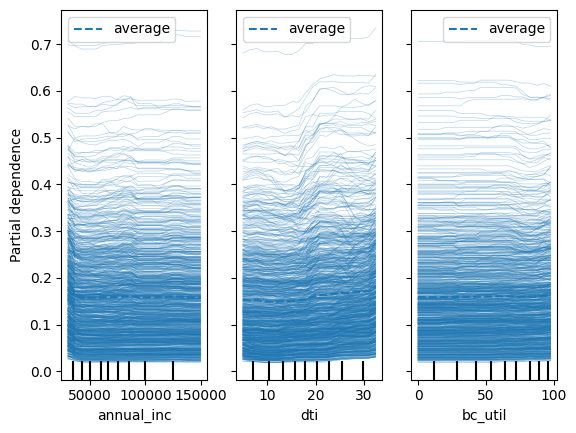

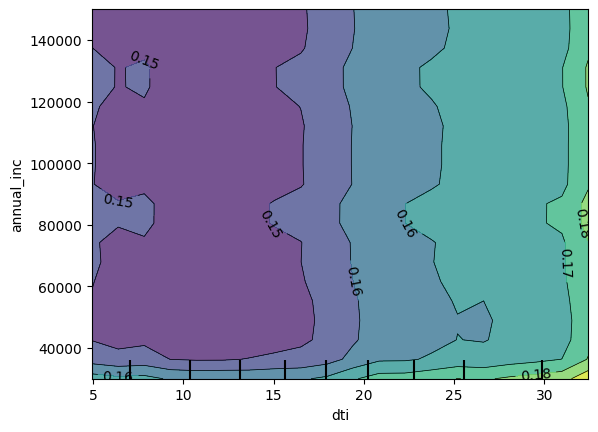

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
num_cols = X_val.select_dtypes(exclude=["object", "category"]).columns.tolist()

# Example: pick a few key numeric features (replace with your top ones)
features_1d = ["annual_inc", "dti", "bc_util"]
features_1d = [f for f in features_1d if f in num_cols]  # keep only those present/numeric

# Optional 2D interaction pairs (both should be numeric)
features_2d = [("dti", "annual_inc")]
features_2d = [pair for pair in features_2d
               if pair[0] in num_cols and pair[1] in num_cols]

# For speed, you can analyze a sample of the validation set
X_val_small = X_val.sample(n=min(2000, len(X_val)), random_state=42)

# ---------------------------
# 2) 1D PDP (with ICE lines)
# ---------------------------
PartialDependenceDisplay.from_estimator(
    estimator=best_model,
    X=X_val_small,
    features=features_1d,
    kind="both",                # "average", "individual", or "both" (PDP + ICE)
    grid_resolution=20,         # increase for smoother curves (slower)
    response_method="auto",     # uses predict_proba for classifiers
    n_jobs=-1                   # parallelize across features/grids
)

# ---------------------------
# 3) 2D PDP (interactions)
# ---------------------------
if features_2d:
    PartialDependenceDisplay.from_estimator(
        estimator=best_model,
        X=X_val_small,
        features=features_2d,   # list of tuples
        kind="average",
        grid_resolution=20,
        response_method="auto",
        n_jobs=-1
    )

In [ ]:
# --- 2) Baseline: with ALL features (including sub_grade_num) ---
from sklearn.base import clone
from sklearn.model_selection import cross_val_score
baseline = clone(best_model)
baseline.fit(X_train, y_train)
auc_full = roc_auc_score(y_val, baseline.predict_proba(X_val)[:, 1])
print(f"Hold-out AUC (with sub_grade_num): {auc_full:.4f}")

# --- 3) Drop sub_grade_num and refit ---
to_drop = "sub_grade_num"
X_train_drop = X_train.drop(columns=[to_drop], errors="ignore")
X_val_drop   = X_val.drop(columns=[to_drop], errors="ignore")

no_sub = clone(best_model)
no_sub.fit(X_train_drop, y_train)
auc_drop = roc_auc_score(y_val, no_sub.predict_proba(X_val_drop)[:, 1])
print(f"Hold-out AUC (without sub_grade_num): {auc_drop:.4f}")
print(f"ΔAUC (drop - full): {auc_drop - auc_full:+.4f}")

# --- 4) (Optional) 5-fold CV to smooth variance ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores_full = cross_val_score(
    clone(best_model), X, y, cv=cv, scoring="roc_auc", n_jobs=-1
)
scores_drop = cross_val_score(
    clone(best_model), X.drop(columns=[to_drop], errors="ignore"),
    y, cv=cv, scoring="roc_auc", n_jobs=-1
)

print(f"CV AUC (with):  mean={scores_full.mean():.4f}  std={scores_full.std():.4f}")
print(f"CV AUC (w/o ):  mean={scores_drop.mean():.4f}  std={scores_drop.std():.4f}")
print(f"ΔCV AUC (w/o - with): {scores_drop.mean() - scores_full.mean():+.4f}")

Hold-out AUC (with sub_grade_num): 0.6939
Hold-out AUC (without sub_grade_num): 0.6866
ΔAUC (drop - full): -0.0074
CV AUC (with):  mean=0.7018  std=0.0043
CV AUC (w/o ):  mean=0.6763  std=0.0047
ΔCV AUC (w/o - with): -0.0255


Hold-out ROC-AUC (no_sub): 0.6866


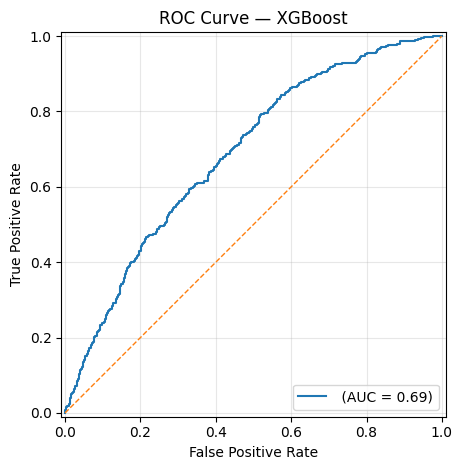

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_auc_score

# --- ROC for the "no_sub" model on the hold-out (X_val_drop, y_val) ---
y_score = no_sub.predict_proba(X_val_drop)[:, 1]
auc_no_sub = roc_auc_score(y_val, y_score)
print(f"Hold-out ROC-AUC (no_sub): {auc_no_sub:.4f}")

disp = RocCurveDisplay.from_predictions(
    y_true=y_val,
    y_pred=y_score,
    name=f""
)

# Diagonal baseline
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.title("ROC Curve — XGBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Hold-out AUC (no sub_grade_num): 0.6768849924418119
                           feature  importance_mean  importance_std
0                   fico_range_low         0.028205        0.007696
1               installment_to_inc         0.023616        0.005761
2                          purpose         0.011310        0.004037
3              verification_status         0.008835        0.004624
4                              dti         0.008593        0.002831
5            mths_since_recent_inq         0.008319        0.002358
6             acc_open_past_24mths         0.007313        0.003606
7             mths_since_recent_bc         0.003264        0.001373
8                   mo_sin_rcnt_tl         0.002627        0.001445
9                        total_acc         0.002018        0.000618
10                      revol_util         0.001630        0.001274
11                       num_il_tl         0.001462        0.001106
12                percent_bc_gt_75         0.001332        0.001

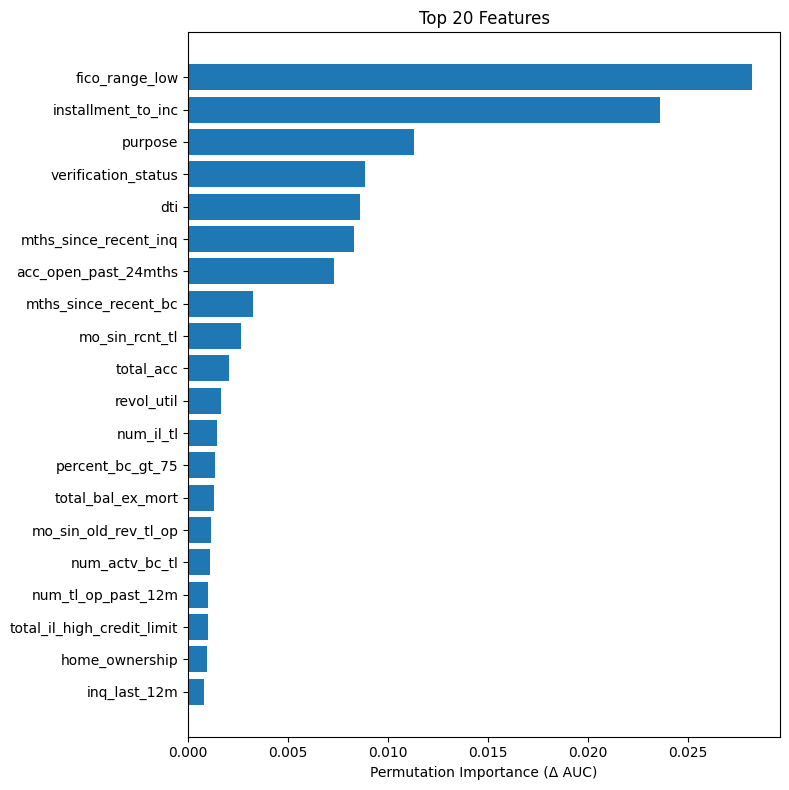

In [ ]:
col_to_drop = "sub_grade_num"
X_train_drop = X_train.drop(columns=[col_to_drop], errors="ignore")
X_val_drop   = X_val.drop(columns=[col_to_drop], errors="ignore")

# --- 3) Fit a cloned best model on the reduced feature set ---
model_no_sub = clone(best_model)   # best_model = your tuned Pipeline
model_no_sub.fit(X_train_drop, y_train)

# Sanity check metric
val_proba = model_no_sub.predict_proba(X_val_drop)[:, 1]
print("Hold-out AUC (no sub_grade_num):", roc_auc_score(y_val, val_proba))

# --- 4) Permutation importance on the hold-out ---
r = permutation_importance(
    estimator=model_no_sub,
    X=X_val_drop,
    y=y_val,
    n_repeats=20,          # increase for more stability if you have time
    scoring="roc_auc",
    random_state=42,
    n_jobs=-1
)

# --- 5) Tidy table + plot ---
imp_df = (
    pd.DataFrame({
        "feature": X_val_drop.columns,
        "importance_mean": r.importances_mean,
        "importance_std": r.importances_std
    })
    .sort_values("importance_mean", ascending=False)
    .reset_index(drop=True)
)

print(imp_df.head(25))

# Bar plot of top-N
topn = 20
plot_df = imp_df.head(topn).iloc[::-1]  # reverse for horizontal
plt.figure(figsize=(8, 8))
plt.barh(plot_df["feature"], plot_df["importance_mean"])
plt.xlabel("Permutation Importance (Δ AUC)")
plt.title(f"Top {topn} Features")
plt.tight_layout()
plt.show()

In [ ]:
#thoughts and considerations
#remove the fico range high variable-- this is correlated to fico range low
#make sure that you didn't set mths since variables to 0 for nulls
#retain on full data set
#take the most relevant features and try to build a log reg model with better AUC

               purpose  avg_pred  delta_vs_baseline
11      small_business  0.210365           0.052461
7              medical  0.189835           0.031931
5                house  0.182352           0.024448
12            vacation  0.179215           0.021311
13             wedding  0.171910           0.014006
8               moving  0.164263           0.006359
10    renewable_energy  0.163742           0.005838
2   debt_consolidation  0.162084           0.004180
4     home_improvement  0.158887           0.000983
6       major_purchase  0.157355          -0.000549
9                other  0.143947          -0.013957
1          credit_card  0.142600          -0.015304
3          educational  0.140198          -0.017706
0                  car  0.137259          -0.020645


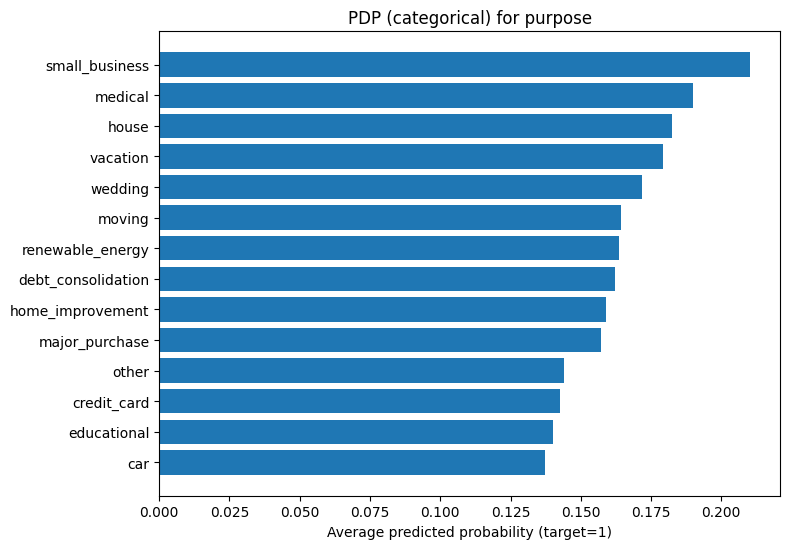

In [ ]:
import matplotlib.pyplot as plt

# Define the categorical column to analyze
purpose_col = 'purpose'

X_val_cat = X_val.copy()
X_val_cat[purpose_col] = X_val_cat[purpose_col].astype('category')
cats = X_val_cat[purpose_col].cat.categories

base = best_model.predict_proba(X_val_cat)[:, 1].mean()
rows = []
for c in cats:
    X_tmp = X_val_cat.copy()
    # assign as a Categorical to avoid object dtype
    X_tmp[purpose_col] = pd.Categorical(np.full(len(X_tmp), c), categories=cats)
    p = best_model.predict_proba(X_tmp)[:, 1].mean()
    rows.append((c, p, p - base))

pdp_df = (pd.DataFrame(rows, columns=[purpose_col, 'avg_pred', 'delta_vs_baseline'])
          .sort_values('avg_pred', ascending=False))
print(pdp_df)

plt.figure(figsize=(8, max(3, 0.4*len(pdp_df))))
plt.barh(pdp_df[purpose_col][::-1], pdp_df['avg_pred'][::-1])
plt.xlabel('Average predicted probability (target=1)')
plt.title(f"PDP (categorical) for {purpose_col}")
plt.tight_layout(); plt.show()

Validation AUC: 0.6768849924418119
                           feature  importance_mean  importance_std
0                   fico_range_low         0.028205        0.007696
1               installment_to_inc         0.023616        0.005761
2                          purpose         0.011310        0.004037
3              verification_status         0.008835        0.004624
4                              dti         0.008593        0.002831
5            mths_since_recent_inq         0.008319        0.002358
6             acc_open_past_24mths         0.007313        0.003606
7             mths_since_recent_bc         0.003264        0.001373
8                   mo_sin_rcnt_tl         0.002627        0.001445
9                        total_acc         0.002018        0.000618
10                      revol_util         0.001630        0.001274
11                       num_il_tl         0.001462        0.001106
12                percent_bc_gt_75         0.001332        0.001063
13           

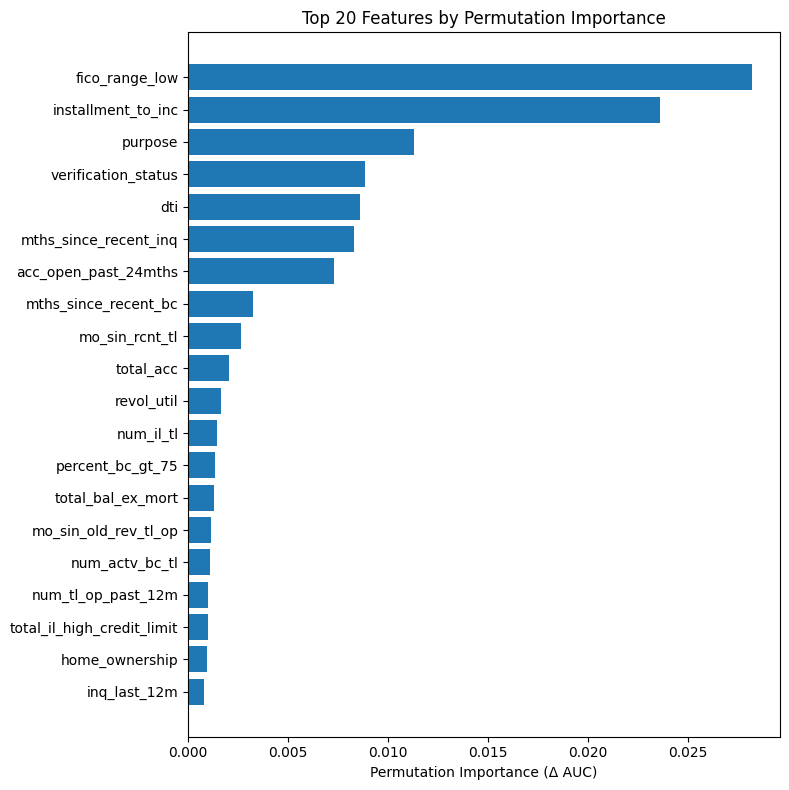

In [ ]:
##using scale_pos_weight

# --- Cast categoricals (keep your original behavior) ---
cat_cols = df_xgb.select_dtypes(include=["object"]).columns
df_xgb[cat_cols] = df_xgb[cat_cols].astype("category")

# --- Target / Features (drop 'sub_grade_num') ---
y = df_xgb["target"].astype(int)
X = df_xgb.drop(columns=["target", "sub_grade_num"], errors="ignore")

# --- Hold-out split ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- Compute scale_pos_weight on TRAIN ONLY (neg/pos) ---
pos = int((y_train == 1).sum())
neg = int((y_train == 0).sum())
scale_pos_weight = (neg / pos) if pos > 0 else 1.0

# --- Apply scale_pos_weight to your model ---
# Case A: you already have an XGBClassifier instance in `best_model`
#         (not a Pipeline)
try:
    best_model.set_params(scale_pos_weight=scale_pos_weight)
except ValueError:
    # Case B: `best_model` is a Pipeline; try common step names
    try:
        best_model.set_params(model__scale_pos_weight=scale_pos_weight)
    except ValueError:
        best_model.set_params(clf__scale_pos_weight=scale_pos_weight)

# If instead you have a best_params dict and want to rebuild:
# params = {**best_params, "scale_pos_weight": scale_pos_weight}
# best_model = XGBClassifier(
#     tree_method="hist",
#     enable_categorical=True,
#     objective="binary:logistic",
#     eval_metric="auc",
#     random_state=42,
#     n_jobs=-1,
#     **params
# )

# --- Fit, validate, and permutation importance ---
best_model.fit(X_train, y_train)

val_proba = best_model.predict_proba(X_val)[:, 1]
print("Validation AUC:", roc_auc_score(y_val, val_proba))

r = permutation_importance(
    estimator=best_model,
    X=X_val,
    y=y_val,
    n_repeats=20,
    scoring="roc_auc",
    random_state=42,
    n_jobs=-1
)

imp_df = (
    pd.DataFrame({
        "feature": X_val.columns,
        "importance_mean": r.importances_mean,
        "importance_std": r.importances_std
    })
    .sort_values("importance_mean", ascending=False)
    .reset_index(drop=True)
)

print(imp_df.head(25))

# (Optional) Plot
import matplotlib.pyplot as plt
topn = 20
ax = imp_df.head(topn).iloc[::-1]
plt.figure(figsize=(8, 8))
plt.barh(ax["feature"], ax["importance_mean"])
plt.xlabel("Permutation Importance (Δ AUC)")
plt.title(f"Top {topn} Features by Permutation Importance")
plt.tight_layout()
plt.show()

## Random Forest Baseline Model

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

# ---------------------------
# 1) X / y  (drop 'sub_grade_num')
# ---------------------------
y = df_xgb["target"].astype(int)
X = df_xgb.drop(columns=["target", "sub_grade_num"], errors="ignore").copy()

# Identify column types
num_cols = X.select_dtypes(include=["number", "bool"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
if cat_cols:
    X[cat_cols] = X[cat_cols].astype("category")

# ---------------------------
# 2) Preprocessing
#    - Numeric: median impute
#    - Categorical: mode impute + OHE (ignore unseen categories)
# ---------------------------
pre = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), cat_cols),
    ],
    remainder="drop",
)

# ---------------------------
# 3) Random Forest (good defaults, no tuning)
# ---------------------------
rf = RandomForestClassifier(
    n_estimators=600,               # solid default for stability
    max_depth=12,                   # curb overfitting/speed up
    min_samples_leaf=2,             # smoother splits
    min_samples_split=10,
    max_features="sqrt",            # standard for classification
    class_weight="balanced_subsample",  # handle imbalance
    bootstrap=True,
    n_jobs=-1,                      # use all cores (safe since no CV grid)
    random_state=42
)

pipe = Pipeline([("pre", pre), ("clf", rf)])

# ---------------------------
# 4) 5-fold CV (metrics) — no tuning, just report
# ---------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"roc_auc": "roc_auc", "pr_auc": "average_precision"}

cv_res = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
print(f"CV ROC-AUC: {np.mean(cv_res['test_roc_auc']):.4f} ± {np.std(cv_res['test_roc_auc']):.4f}")
print(f"CV PR-AUC : {np.mean(cv_res['test_pr_auc']):.4f} ± {np.std(cv_res['test_pr_auc']):.4f}")

# ---------------------------
# 5) Fit final model on ALL data (for deployment/inference)
# ---------------------------
pipe.fit(X, y)

# ---------------------------
# 6) (Optional) Feature importances with names
# ---------------------------
feat_names = pipe.named_steps["pre"].get_feature_names_out()
importances = pipe.named_steps["clf"].feature_importances_
imp_df = (pd.DataFrame({"feature": feat_names, "importance": importances})
            .sort_values("importance", ascending=False)
            .reset_index(drop=True))
print(imp_df.head(25))

CV ROC-AUC: 0.6618 ± 0.0076
CV PR-AUC : 0.2661 ± 0.0151
                            feature  importance
0           num__installment_to_inc    0.049120
1               num__fico_range_low    0.045168
2                          num__dti    0.035383
3               num__bc_open_to_buy    0.026359
4                   num__revol_util    0.024811
5                      num__bc_util    0.024124
6                    num__revol_bal    0.023458
7                   num__annual_inc    0.023395
8             num__total_rev_hi_lim    0.023285
9              num__tot_hi_cred_lim    0.023036
10              num__total_bc_limit    0.022765
11                 num__avg_cur_bal    0.022499
12      num__earliest_cr_line_years    0.022476
13        num__mo_sin_old_rev_tl_op    0.021835
14                  num__bal_to_inc    0.021639
15        num__mths_since_recent_bc    0.021428
16                 num__tot_cur_bal    0.020859
17           num__total_bal_ex_mort    0.020488
18          num__mo_sin_old_il_a

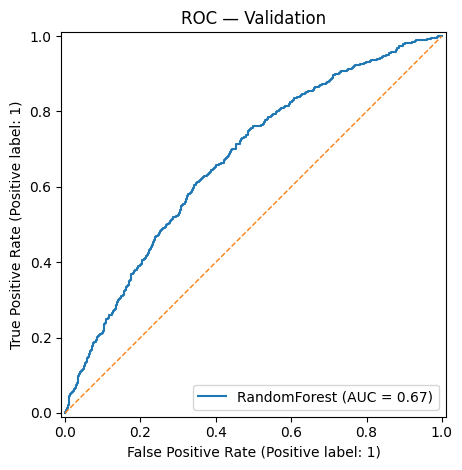

Hold-out ROC-AUC: 0.6698401209310112


In [ ]:
# 0) Hold-out split (uses your X, y which already drop 'sub_grade_num')
X_tr, X_va, y_tr, y_va = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 1) Fit on train
pipe.fit(X_tr, y_tr)

# 2) ROC curve on validation
RocCurveDisplay.from_estimator(
    estimator=pipe, X=X_va, y=y_va, name="RandomForest"
)
plt.plot([0, 1], [0, 1], "--", linewidth=1)
plt.title("ROC — Validation")
plt.tight_layout()
plt.show()

# (optional: print the numeric AUC)
y_score = pipe.predict_proba(X_va)[:, 1]
print("Hold-out ROC-AUC:", roc_auc_score(y_va, y_score))

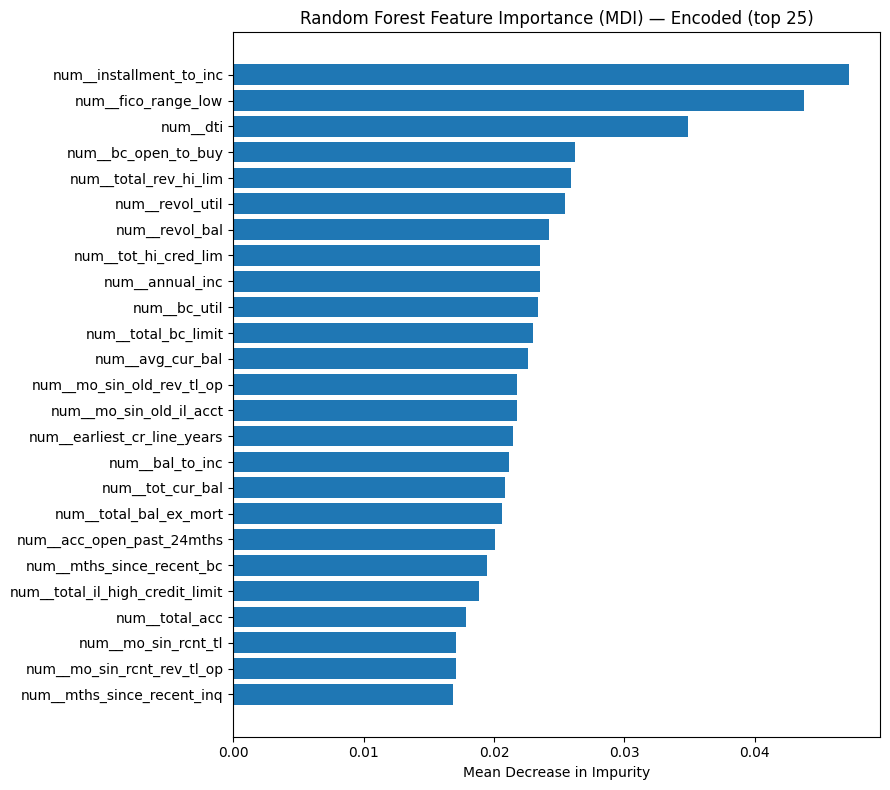

               feature_raw  importance
0       installment_to_inc    0.047239
1           fico_range_low    0.043786
2                      dti    0.034896
3           bc_open_to_buy    0.026229
4         total_rev_hi_lim    0.025927
5               revol_util    0.025439
6                revol_bal    0.024213
7          tot_hi_cred_lim    0.023533
8               annual_inc    0.023508
9                  bc_util    0.023374
10          total_bc_limit    0.022959
11             avg_cur_bal    0.022610
12    mo_sin_old_rev_tl_op    0.021737
13      mo_sin_old_il_acct    0.021735
14  earliest_cr_line_years    0.021432
15              bal_to_inc    0.021115
16             tot_cur_bal    0.020825
17       total_bal_ex_mort    0.020604
18    acc_open_past_24mths    0.020098
19    mths_since_recent_bc    0.019475


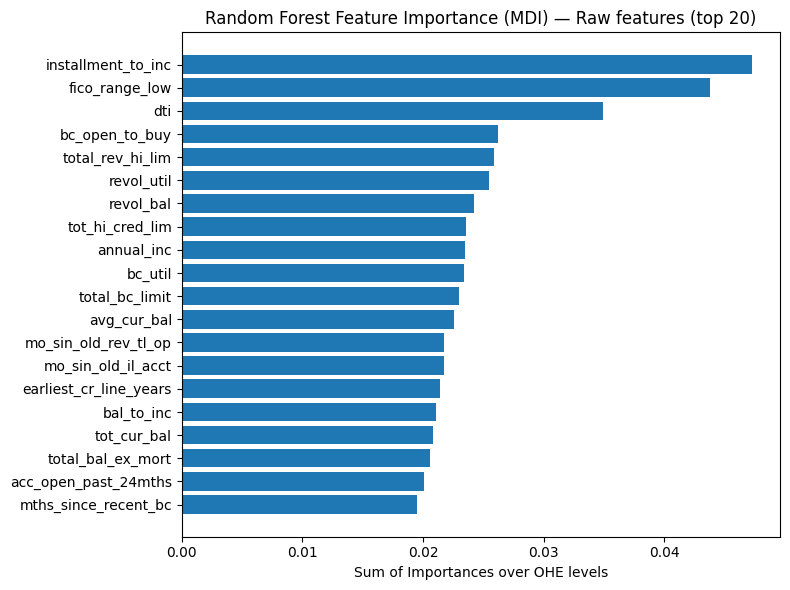

In [ ]:
# 1) Get encoded feature names + importances
pre = pipe.named_steps["pre"]
rf  = pipe.named_steps["clf"]

feat_names = pre.get_feature_names_out()          # e.g., ["num__int_rate", "cat__ohe__purpose_debt_consolidation", ...]
importances = rf.feature_importances_

imp_enc = (pd.DataFrame({"feature_enc": feat_names, "importance": importances})
             .sort_values("importance", ascending=False)
             .reset_index(drop=True))

# --- Plot (encoded features): top 25
topn = 25
ax_df = imp_enc.head(topn).iloc[::-1]
plt.figure(figsize=(9, 8))
plt.barh(ax_df["feature_enc"], ax_df["importance"])
plt.title(f"Random Forest Feature Importance (MDI) — Encoded (top {topn})")
plt.xlabel("Mean Decrease in Impurity")
plt.tight_layout()
plt.show()

# 2) (Optional) Aggregate OHE columns back to their original feature
def base_feature(name: str) -> str:
    if name.startswith("num__"):
        return name.split("num__", 1)[1]
    if name.startswith("cat__ohe__"):
        rest = name.split("cat__ohe__", 1)[1]
        # OHE names look like "<feature>_<category>"; take everything before the last "_"
        return rest.rsplit("_", 1)[0] if "_" in rest else rest
    # fallback
    return name

imp_enc["feature_raw"] = imp_enc["feature_enc"].map(base_feature)

imp_raw = (imp_enc.groupby("feature_raw", as_index=False)["importance"]
                 .sum()
                 .sort_values("importance", ascending=False)
                 .reset_index(drop=True))

print(imp_raw.head(20))  # table view

# --- Plot (raw/original features): top 20
topn_raw = 20
ax_df2 = imp_raw.head(topn_raw).iloc[::-1]
plt.figure(figsize=(8, 6))
plt.barh(ax_df2["feature_raw"], ax_df2["importance"])
plt.title(f"Random Forest Feature Importance (MDI) — Raw features (top {topn_raw})")
plt.xlabel("Sum of Importances over OHE levels")
plt.tight_layout()
plt.show()